# Pipeline practices

## Breast cancer dataset

569 examples of malignant and benign tumor cells.

The first two columns in the dataset store the unique ID numbers of the examples and the corresponding diagnoses (M = malignant, B = benign), respectively.

Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant. 

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.shape

(569, 32)

In [6]:
X= df.loc[:,2:].values
y= df.loc[:,1].values

econcoding labels to the outcome variable

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

To check which label is which, we can call the `transform` method

In [8]:
le.transform(['M','B'])

array([1, 0])

train test split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.2, stratify= y)

# Combining transformers and estimators in a pipeline

We want to do the following:
- Standardize the variables
- PCA

Instead of doing those separately, we can chain the `StandardScaler, PCA`and `LogisticRegression` in a pipeline

Go to the [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) for more, but how it works is that everything before the last argument has to have the `fit` and `transform` method, as they are the *transformers*. The last argument will be an estimator, which the function will only apply `fit`

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [12]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
    )

When calling `fit`, the `fit_transform` is automatically applied in the pipeline for the standardization and PCA

In [13]:
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

When `predict` is called, `transformation` is applied for standardization and pca in the pipeline

In [14]:
y_pred = pipe_lr.predict(X_test)

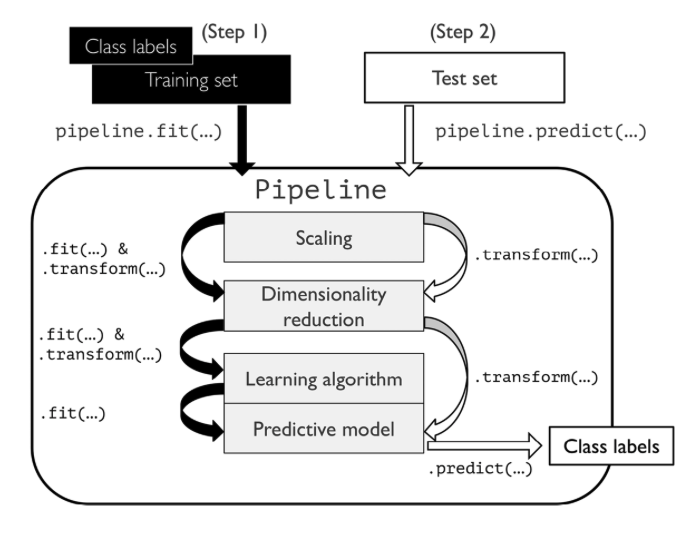

`.score` can also be used after pipeline to get the accuracy score 

## Stratified K Fold

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [16]:
k_fold = StratifiedKFold(n_splits =10).split(X_train,y_train)

A more "manual" way of doing stratified k-fold

In [17]:
scores = []
for k, (train, test) in enumerate(k_fold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
scores = cross_val_score(
    estimator = pipe_lr,
    X = X_train,
    y= y_train,
    cv =10,
    n_jobs =1
)
np.mean(scores)
np.std(scores)
scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

## Learning curve and validation curves

In [20]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import learning_curve # Determines cv training and test scores for different training test size

In [21]:
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2',max_iter=10000)) ## use mx_iter to avoid convergence issues of smaller data or extreme regularization

train_sizes, train_scores, test_scores = learning_curve(
    estimator = pipe_lr,
    X = X_train, # does not use the whole datase, rather the training section of the data 
    y =y_train,
    train_sizes = np.linspace(0.1,1.0,10),
    cv=10, n_jobs =1)


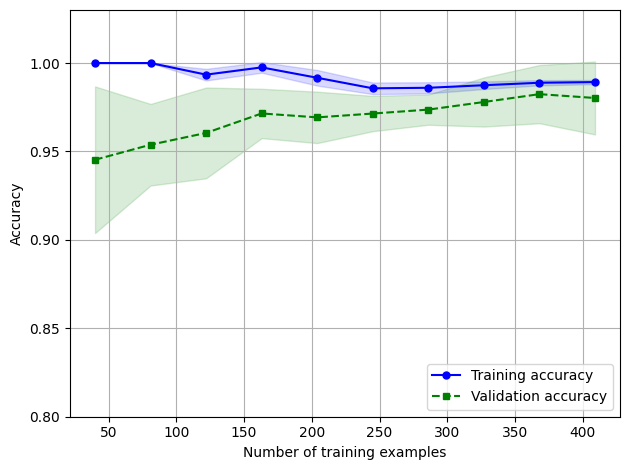

In [22]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue') ## Adds the standard deviation

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

## Validation curve

In [23]:
from sklearn.model_selection import validation_curve


In [24]:
param_range = [0.001,0.01,0.1,1.0,10,100.0]

train_scores, test_scores = validation_curve(
    pipe_lr,X_train,y_train,param_range = param_range, param_name = 'logisticregression__C', cv =10, n_jobs = 1
)

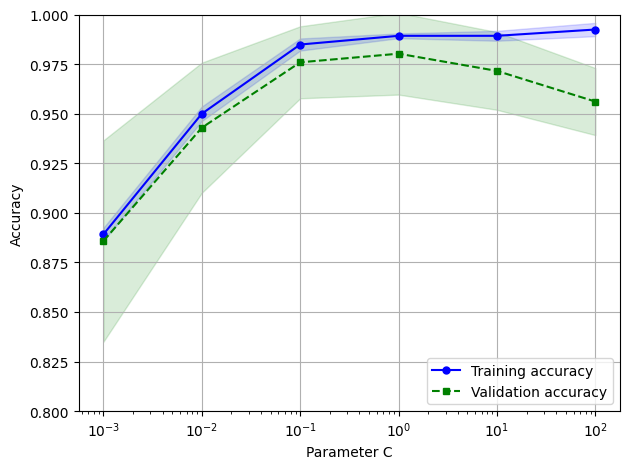

In [25]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

# Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [27]:
pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)


we have to specify that the param C belongs in SVC since we are fitting a pipeline

What this book is doing is a bit different, probably just to save computing power. But basically what I did in the SVM thing is that  I made a dict which try every possible combinations. This code made 2 dicts, trying out 2 sets of combinations only.

In [28]:

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

refit  = True this is goated as it refits the estimator, we don't have to call another funciton to fit it again.

normally we would have to call clf = gs.best_estimator_ then clf.fit(X_train,y_train) after fitting the GS


In [29]:
gs = GridSearchCV(
    estimator = pipe_svc,
    param_grid = param_grid,
    scoring = 'accuracy',
    refit = True, 
    cv = 10
)
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=1))]),
             param_grid=[{'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100.0],
                          'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100.0],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')

In [30]:
print(gs.best_score_)
print(gs.best_params_)


0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Extract out the best estimator, assign it to anotha var and then use `score` to fit it to the test set

In [31]:
clf = gs.best_estimator_
clf.score(X_test,y_test)

0.9736842105263158

# Randomized Search

The only difference between two use cases are `n_iter =20`, which says how many times the algo should randomly try values

In [32]:
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]


rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

In [ ]:
rs = rs.fit(X_train, y_train)
print(rs.best_score_)

In [ ]:

print(rs.best_params_)

A more efficient way of doing it (check obsidian page). `HalvingRandomSearchCV` is still experimental

In [ ]:
from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import HalvingRandomSearchCV
'''  

resource='n_samples', #specifies that we consider the training set size as the resource we vary between the rounds

#we can determine how many candidates are eliminated in each round. means that only 100%/1.5 ≈ 66% of the candidates make it into the next round

Instead of choosing a fixed number of iterations as in RandomizedSearchCV, we set n_candidates='exhaust' (default),
which will sample the number of hyperparameter configurations such that the maximum number of 
resources (here: training examples) are used in the last round.
'''  
hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples', 
    factor=1.5, 
    random_state=1,
    n_jobs=-1)

In [ ]:
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

In [ ]:
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

# ROC and AUC

In [34]:
from sklearn.metrics import roc_curve, auc 
from numpy import interp

In [35]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))


In [36]:
X_train2 = X_train[:, [4, 14]]
    

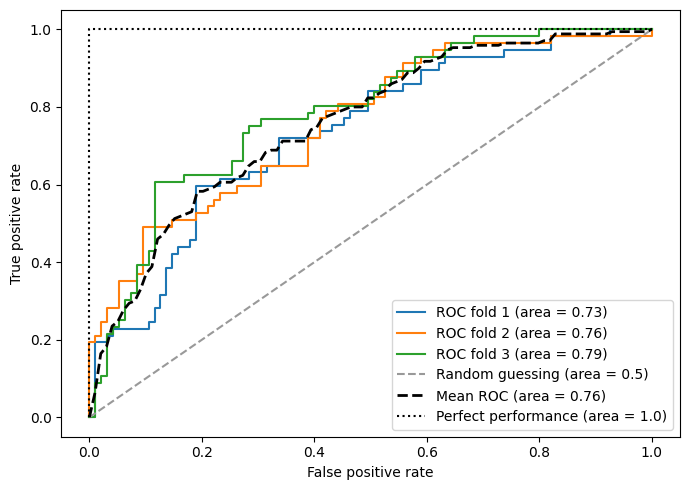

In [38]:
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train)) 
'''
The stratification will remian the class balance betwene the classes. K =3, meaning that the data will be split into 3 folds
'''
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0 # mean true positive rate
mean_fpr = np.linspace(0, 1, 100) # mean fale positive rate
all_tpr = []

for i, (train, test) in enumerate(cv): # for each train test index
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test]) # fit the pipeline on inex i of the fold you created. then predict probability on the test set

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1], #equivalent of y_pred
                                     pos_label=1) # The threshold array just returns the thresholds that were used to get the fpr and tpr values
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
# plt.savefig('figures/06_10.png', dpi=300)
plt.show()